# CS634 Final Project: SMS Spam Classification
Name : Tushar Jain                                                                                                         
UCID : TJ277

### Project Goal

The primary goal of this project is to implement and compare multiple machine learning classification algorithms along with a deep learning model to predict whether an SMS message is **spam** or **ham** (legitimate). 
This prediction is based on the textual content and linguistic patterns present in the messages.


### Models Used
- **Random Forest** (Traditional ML)
- **Naive Bayes** (Probability-based ML model)
- **Bi-LSTM** (Deep Learning)


### What I'll Do
1. Analyze message patterns and word distributions
2. Train all three models with optimal parameters
3. Evaluate using 10-fold validation and 17 metrics
4. Compare performance to find the best spam detector
5. Recommend the best approach for real-world use




 

#### Prerequisites Before Running the Jupyter Notebook

#### 1. Check Python Version
Your Python version must be 3.8 or higher

python --version





#### 2. Check the dataset should be in right folder 

├── data/                                                                                                                  
│   └── sms_spam.csv                                                                                                       
└── sms_spam.ipynb

#### 3. Install Requirements in VS Code Terminal

pip install -r requirements.txt

In [6]:
## 1. Importing Packages and Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Deep Learning imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Utility imports
import joblib
import json
import os

print("All packages imported successfully!")

All packages imported successfully!


In [47]:
## 2. Loading Prepared Data

df = pd.read_csv('data/sms_spam.csv')
print(f"Dataset shape: {df.shape}")

print("\nDataset Info:")
df.info()

print("\nBasic Statistics:")
print(df.describe())

print(df.isnull().sum())

# Check data types and unique values
print(df['label'].value_counts())


Dataset shape: (5572, 3)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   int64 
 1   text        5572 non-null   object
 2   text_clean  5570 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB

Basic Statistics:
             label
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
label         0
text          0
text_clean    2
dtype: int64
label
0    4825
1     747
Name: count, dtype: int64


In [41]:
## 2.1 Data Quality Verification

if 'text_clean' not in df.columns:
    raise ValueError("'text_clean' column not found in the dataset!")

empty_texts = df['text_clean'].isna().sum() + (df['text_clean'].str.len() == 0).sum()
print(f"Empty or NaN texts: {empty_texts}")

# Remove any empty texts if they exist
if empty_texts > 0:
    df = df[df['text_clean'].notna() & (df['text_clean'].str.len() > 0)]
    print(f"Removed {empty_texts} empty texts. New shape: {df.shape}")

for i in range(3):
    print(f"Label: {df.iloc[i]['label']} | Text: {df.iloc[i]['text_clean'][:100]}...")

Empty or NaN texts: 0
Label: 0 | Text: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore w...
Label: 0 | Text: ok lar joking wif u oni...
Label: 1 | Text: free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry...


In [9]:
## 2.2 Separating Dataset into Features and Output Label

# Feature and label separation
features = df['text_clean']
labels = df['label']

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution:\n{labels.value_counts()}")

Features shape: (5570,)
Labels shape: (5570,)
Label distribution:
label
0    4823
1     747
Name: count, dtype: int64


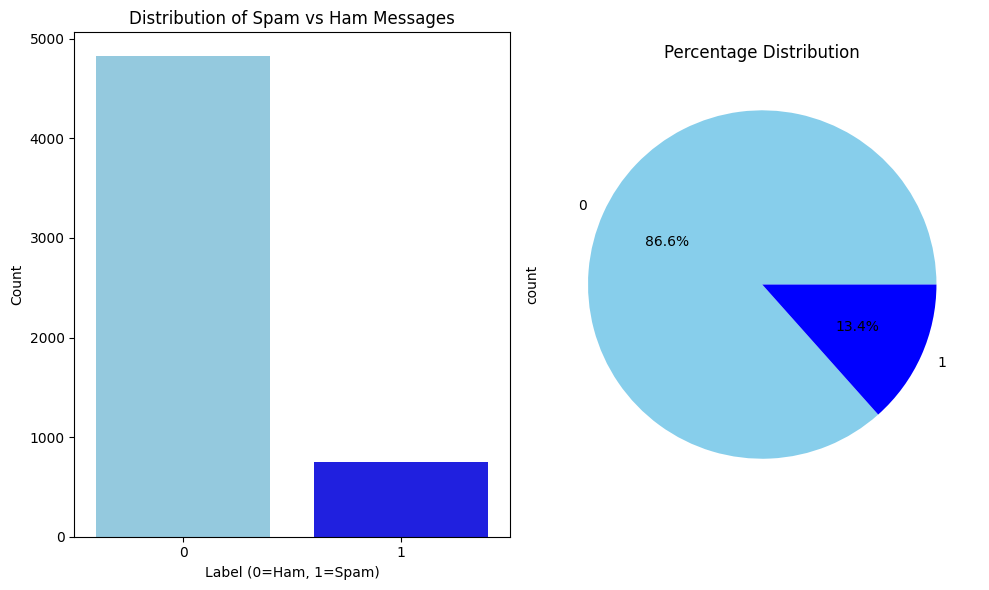

Checking for Data Imbalance
Number of Spam Messages (Positive):  747
Percentage of Spam Messages: 13.41%
Number of Ham Messages (Negative):  4823
Percentage of Ham Messages: 86.59%




In [36]:
## 2.3 Data Visualization

# Visualizing the distribution of the target variable
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=labels, palette=['skyblue', 'blue'])
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
labels.value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'blue'])
plt.title('Percentage Distribution')

plt.tight_layout()
plt.show()

# Checking for data imbalance
positive_outcomes = labels.sum()  # Spam messages
negative_outcomes = len(labels) - positive_outcomes  # Ham messages
total_samples = len(labels)

print('Checking for Data Imbalance')
print('Number of Spam Messages (Positive): ', positive_outcomes)
print('Percentage of Spam Messages: {}%'.format(round((positive_outcomes / total_samples) * 100, 2)))
print('Number of Ham Messages (Negative): ', negative_outcomes)
print('Percentage of Ham Messages: {}%'.format(round((negative_outcomes / total_samples) * 100, 2)))
print('\n')

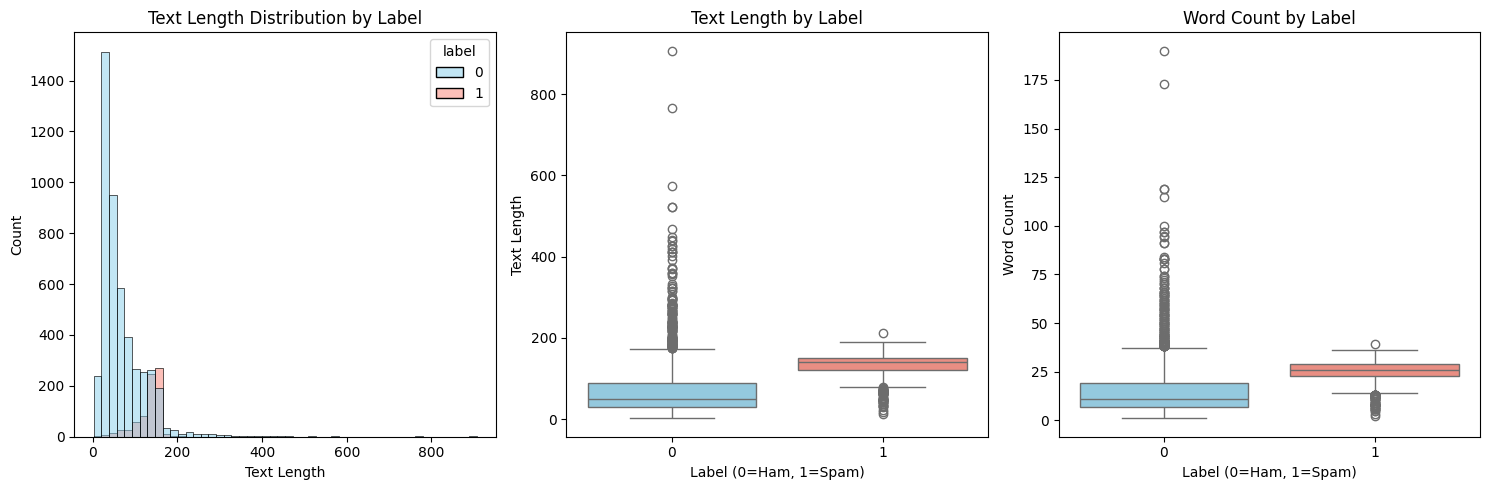

Text Length Statistics by Label:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4823.0   67.816297  55.636249   2.0   31.0   50.0   88.0  907.0
1       747.0  131.206158  28.490445  13.0  122.0  141.0  151.0  211.0


In [11]:
## 2.4 Text Length Analysis

# Analyze text length distribution
df['text_length'] = df['text_clean'].str.len()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data=df, x='text_length', hue='label', bins=50, palette=['skyblue', 'salmon'])
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='label', y='text_length', palette=['skyblue', 'salmon'])
plt.title('Text Length by Label')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Text Length')

plt.subplot(1, 3, 3)
# Word count analysis
df['word_count'] = df['text_clean'].str.split().str.len()
sns.boxplot(data=df, x='label', y='word_count', palette=['skyblue', 'salmon'])
plt.title('Word Count by Label')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

print("Text Length Statistics by Label:")
print(df.groupby('label')['text_length'].describe())

In [12]:
## 2.5 Feature Engineering

# Initialize vectorizers

# Count Vectorizer
count_vec = CountVectorizer(max_features=5000, stop_words='english')
X_count = count_vec.fit_transform(features)

# TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vec.fit_transform(features)

# Prepare sequences for LSTM
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
sequences = tokenizer.texts_to_sequences(features)
X_seq = pad_sequences(sequences, maxlen=100)

print(f"Count Vectorizer shape: {X_count.shape}")
print(f"TF-IDF Vectorizer shape: {X_tfidf.shape}")
print(f"LSTM Sequences shape: {X_seq.shape}")

# Display vocabulary sizes
print(f"Vocabulary size (Count): {len(count_vec.vocabulary_)}")
print(f"Vocabulary size (TF-IDF): {len(tfidf_vec.vocabulary_)}")
print(f"Vocabulary size (LSTM): {len(tokenizer.word_index)}")

Initializing feature engineering...
Feature engineering completed!
Count Vectorizer shape: (5570, 5000)
TF-IDF Vectorizer shape: (5570, 5000)
LSTM Sequences shape: (5570, 100)
Vocabulary size (Count): 5000
Vocabulary size (TF-IDF): 5000
Vocabulary size (LSTM): 8688


In [14]:
## 2.6 Train-Test Split

# Perform train-test split with stratification
X_train_indices, X_test_indices, y_train, y_test = train_test_split(
    range(len(features)), labels, test_size=0.2, random_state=42, stratify=labels
)

# For Random Forest and Naive Bayes (using TF-IDF and Count features)
X_train_tfidf = X_tfidf[X_train_indices]
X_test_tfidf = X_tfidf[X_test_indices]
X_train_count = X_count[X_train_indices]
X_test_count = X_count[X_test_indices]

# For LSTM - use the actual indices to slice the sequences
X_train_seq = X_seq[X_train_indices]
X_test_seq = X_seq[X_test_indices]
y_train_lstm = y_train.values  
y_test_lstm = y_test.values    

print("Train-Test Split completed!")
print(f"Training set size: {len(X_train_indices)}")
print(f"Testing set size: {len(X_test_indices)}")
print(f"Training labels distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Testing labels distribution: {pd.Series(y_test).value_counts().to_dict()}")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

Train-Test Split completed!
Training set size: 4456
Testing set size: 1114
Training labels distribution: {0: 3858, 1: 598}
Testing labels distribution: {0: 965, 1: 149}
X_train_seq shape: (4456, 100)
X_test_seq shape: (1114, 100)
y_train_lstm shape: (4456,)
y_test_lstm shape: (1114,)


In [15]:
## 2.7 Define Metrics Calculation Functions

def calc_metrics(confusion_matrix):
   
    TN, FP, FN, TP = confusion_matrix.ravel()
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    FPR = FP / (TN + FP) if (TN + FP) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    F1_measure = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) if ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) != 0 else 0
    
    metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, 
               Accuracy, Error_rate, BACC, TSS, HSS]
    return metrics

def get_metrics(model, X_train, X_test, y_train, y_test, model_type):
    
    
    if model_type == 'bilstm':
        # LSTM model training and prediction
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, 
                          validation_data=(X_test, y_test),
                          epochs=20, batch_size=64, 
                          callbacks=[early_stop], verbose=0)
        
        
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        matrix = confusion_matrix(y_test, y_pred)
        brier_score = brier_score_loss(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
    else:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        
        matrix = confusion_matrix(y_test, y_pred)
        brier_score = brier_score_loss(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
    
    metrics = calc_metrics(matrix)
    metrics.extend([brier_score, roc_auc, accuracy])
    
    return metrics

# Define metric columns for results
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision',
                 'F1_measure', 'Accuracy', 'Error_rate', 'BACC', 'TSS', 'HSS',
                 'Brier_score', 'AUC', 'Acc_by_package_fn']



Metrics calculation functions defined!


In [16]:
## 3. Model Selection and Parameter Tuning

### 3.1 Random Forest Parameter Tuning


param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, 
                             cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_tfidf, y_train)

best_rf_params = grid_search_rf.best_params_
print("Best Parameters for Random Forest:", best_rf_params)

n_estimators_rf = best_rf_params['n_estimators']
max_depth_rf = best_rf_params['max_depth']
min_samples_split_rf = best_rf_params['min_samples_split']

Tuning Random Forest parameters...
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}


In [17]:
### 3.2 Naive Bayes Parameter Tuning


param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

nb_classifier = MultinomialNB()
grid_search_nb = GridSearchCV(estimator=nb_classifier, param_grid=param_grid_nb, 
                             cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train_count, y_train)

best_nb_params = grid_search_nb.best_params_
print("Best Parameters for Naive Bayes:", best_nb_params)

alpha_nb = best_nb_params['alpha']

Tuning Naive Bayes parameters...
Best Parameters for Naive Bayes: {'alpha': 2.0}


In [37]:
### 3.3 Bi-LSTM Model Architecture


def create_bilstm_model():
    
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

# Test model creation
bilstm_model = create_bilstm_model()


In [21]:
## 4. Model Training with 10-Fold Stratified Cross-Validation

print("Starting 10-Fold Stratified Cross-Validation...")

cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_metrics_list, nb_metrics_list, bilstm_metrics_list = [], [], []

# Prepare feature sets for cross-validation
X_tfidf_array = X_tfidf.toarray() 
X_count_array = X_count.toarray()  
fold = 0
for train_index, test_index in cv_stratified.split(X_tfidf_array, labels):
    fold += 1
    print(f"\nFold {fold} ")
    
    
    X_train_tfidf_fold = X_tfidf_array[train_index]
    X_test_tfidf_fold = X_tfidf_array[test_index]
    X_train_count_fold = X_count_array[train_index]
    X_test_count_fold = X_count_array[test_index]
    X_train_seq_fold = X_seq[train_index]
    X_test_seq_fold = X_seq[test_index]
    y_train_fold = labels.iloc[train_index]
    y_test_fold = labels.iloc[test_index]
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators_rf,
        max_depth=max_depth_rf,
        min_samples_split=min_samples_split_rf,
        random_state=42,
        n_jobs=-1
    )
    
    nb_model = MultinomialNB(alpha=alpha_nb)
    
    bilstm_model = create_bilstm_model()
    
    print("Training Random Forest .")
    rf_metrics = get_metrics(rf_model, X_train_tfidf_fold, X_test_tfidf_fold, 
                           y_train_fold, y_test_fold, 'rf')
    
    print("Training Naive Bayes.")
    nb_metrics = get_metrics(nb_model, X_train_count_fold, X_test_count_fold, 
                           y_train_fold, y_test_fold, 'nb')
    
    print("Training Bi-LSTM.")
    bilstm_metrics = get_metrics(bilstm_model, X_train_seq_fold, X_test_seq_fold, 
                               y_train_fold, y_test_fold, 'bilstm')
    
    rf_metrics_list.append(rf_metrics)
    nb_metrics_list.append(nb_metrics)
    bilstm_metrics_list.append(bilstm_metrics)
    
    metrics_fold_df = pd.DataFrame([rf_metrics, nb_metrics, bilstm_metrics], 
                                 columns=metric_columns, 
                                 index=['RF', 'NB', 'Bi-LSTM'])
    
    print(f"\nMetrics for Fold {fold}:")
    print(metrics_fold_df[['Accuracy', 'Precision', 'F1_measure', 'AUC']].round(3).T)

print("\n10-Fold Cross-Validation completed!")

Starting 10-Fold Stratified Cross-Validation...

--- Fold 1 ---
Training Random Forest...
Training Naive Bayes...
Training Bi-LSTM...

Metrics for Fold 1:
               RF     NB  Bi-LSTM
Accuracy    0.982  0.993    0.996
Precision   1.000  1.000    1.000
F1_measure  0.928  0.972    0.986
AUC         0.992  0.985    0.990

--- Fold 2 ---
Training Random Forest...
Training Naive Bayes...
Training Bi-LSTM...

Metrics for Fold 2:
               RF     NB  Bi-LSTM
Accuracy    0.977  0.986    0.989
Precision   0.984  0.958    0.972
F1_measure  0.905  0.945    0.959
AUC         0.995  0.994    0.997

--- Fold 3 ---
Training Random Forest...
Training Naive Bayes...
Training Bi-LSTM...

Metrics for Fold 3:
               RF     NB  Bi-LSTM
Accuracy    0.971  0.973    0.987
Precision   0.968  0.893    1.000
F1_measure  0.882  0.899    0.950
AUC         0.995  0.987    0.993

--- Fold 4 ---
Training Random Forest...
Training Naive Bayes...
Training Bi-LSTM...

Metrics for Fold 4:
              

AVERAGE PERFORMANCE ACROSS ALL FOLDS - ALL MODELS

COMPREHENSIVE AVERAGE METRICS :
                   Random Forest  Naive Bayes  Bi-LSTM
TP                        64.300       69.200   70.400
TN                       481.500      478.100  480.600
FP                         0.800        4.200    1.700
FN                        10.400        5.500    4.300
TPR                        0.861        0.926    0.942
TNR                        0.998        0.991    0.996
FPR                        0.002        0.009    0.004
FNR                        0.139        0.074    0.058
Precision                  0.988        0.943    0.977
F1_measure                 0.919        0.935    0.959
Accuracy                   0.980        0.983    0.989
Error_rate                 0.020        0.017    0.011
BACC                       0.930        0.959    0.969
TSS                        0.859        0.918    0.939
HSS                        0.908        0.924    0.953
Brier_score                0.019     

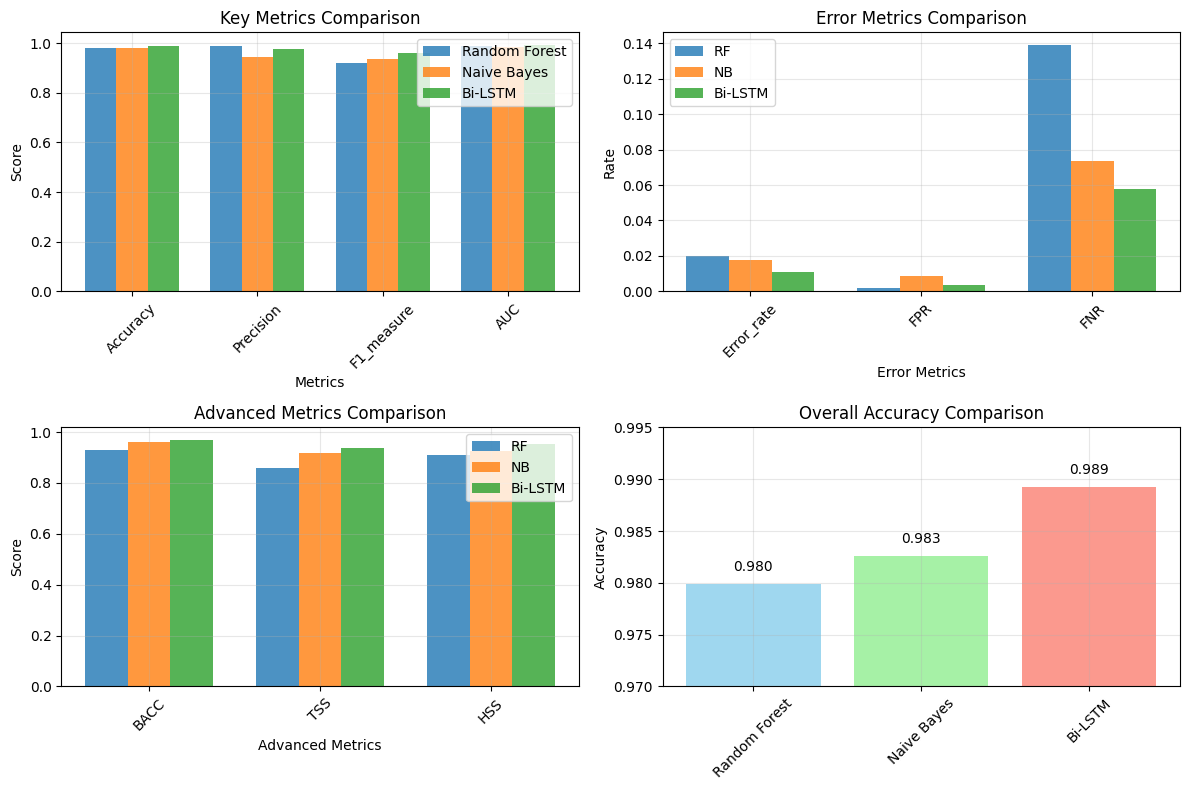


STATISTICAL SUMMARY:
Total Folds Analyzed: 10
Total Metrics per Model: 17
Best Accuracy: 0.989 (Bi-LSTM)
Worst Accuracy: 0.980 (Random Forest)
Average Accuracy Across Models: 0.984
AVERAGE PERFORMANCE ANALYSIS COMPLETED!


In [46]:
## Calculate and Display Average Performance Across All Folds

print("AVERAGE PERFORMANCE ACROSS ALL FOLDS - ALL MODELS")

# Calculate averages for each model
rf_avg = rf_metrics_df.mean()
nb_avg = nb_metrics_df.mean()
bilstm_avg = bilstm_metrics_df.mean()

# Create comprehensive comparison DataFrame
avg_comparison = pd.DataFrame({
    'Random Forest': rf_avg,
    'Naive Bayes': nb_avg,
    'Bi-LSTM': bilstm_avg
})

# Display full average metrics
print("\nCOMPREHENSIVE AVERAGE METRICS :")
print(avg_comparison.round(3))

# Display key metrics comparison
key_metrics = ['Accuracy', 'Precision', 'F1_measure', 'AUC', 'BACC', 'TSS', 'HSS', 'Brier_score']
print("\nKEY METRICS COMPARISON:")
print(avg_comparison.loc[key_metrics].round(3))

# Performance ranking
print("\nPERFORMANCE RANKING:")
models_ranking = avg_comparison.loc['Accuracy'].sort_values(ascending=False)
for i, (model, score) in enumerate(models_ranking.items(), 1):
    print(f"{i}. {model}: {score:.3f}")

# Best model overall (based on multiple metrics)
overall_score = (avg_comparison.loc[['Accuracy', 'F1_measure', 'AUC', 'BACC']].mean())
best_model = overall_score.idxmax()
print(f"\nBEST OVERALL MODEL: {best_model}")
print(f"Overall Score: {overall_score[best_model]:.3f}")

# Create visual comparison
print("\nVISUAL PERFORMANCE COMPARISON:")
plt.figure(figsize=(12, 8))

# Plot 1: Key Metrics Comparison
plt.subplot(2, 2, 1)
key_metrics_data = avg_comparison.loc[['Accuracy', 'Precision', 'F1_measure', 'AUC']]
x = range(len(key_metrics_data.index))
width = 0.25

plt.bar([i - width for i in x], key_metrics_data['Random Forest'], width, label='Random Forest', alpha=0.8)
plt.bar(x, key_metrics_data['Naive Bayes'], width, label='Naive Bayes', alpha=0.8)
plt.bar([i + width for i in x], key_metrics_data['Bi-LSTM'], width, label='Bi-LSTM', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Key Metrics Comparison')
plt.xticks(x, key_metrics_data.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error Metrics Comparison
plt.subplot(2, 2, 2)
error_metrics = ['Error_rate', 'FPR', 'FNR']
error_data = avg_comparison.loc[error_metrics]

x_error = range(len(error_metrics))
plt.bar([i - width for i in x_error], error_data['Random Forest'], width, label='RF', alpha=0.8)
plt.bar(x_error, error_data['Naive Bayes'], width, label='NB', alpha=0.8)
plt.bar([i + width for i in x_error], error_data['Bi-LSTM'], width, label='Bi-LSTM', alpha=0.8)

plt.xlabel('Error Metrics')
plt.ylabel('Rate')
plt.title('Error Metrics Comparison')
plt.xticks(x_error, error_metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Advanced Metrics Comparison
plt.subplot(2, 2, 3)
advanced_metrics = ['BACC', 'TSS', 'HSS']
advanced_data = avg_comparison.loc[advanced_metrics]

x_adv = range(len(advanced_metrics))
plt.bar([i - width for i in x_adv], advanced_data['Random Forest'], width, label='RF', alpha=0.8)
plt.bar(x_adv, advanced_data['Naive Bayes'], width, label='NB', alpha=0.8)
plt.bar([i + width for i in x_adv], advanced_data['Bi-LSTM'], width, label='Bi-LSTM', alpha=0.8)

plt.xlabel('Advanced Metrics')
plt.ylabel('Score')
plt.title('Advanced Metrics Comparison')
plt.xticks(x_adv, advanced_metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Overall Accuracy Comparison
plt.subplot(2, 2, 4)
models = ['Random Forest', 'Naive Bayes', 'Bi-LSTM']
accuracies = [avg_comparison.loc['Accuracy', model] for model in models]
colors = ['skyblue', 'lightgreen', 'salmon']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Overall Accuracy Comparison')
plt.ylim(0.97, 0.995)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{accuracy:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("\nSTATISTICAL SUMMARY:")
print(f"Total Folds Analyzed: 10")
print(f"Total Metrics per Model: 17")
print(f"Best Accuracy: {avg_comparison.loc['Accuracy'].max():.3f} ({avg_comparison.loc['Accuracy'].idxmax()})")
print(f"Worst Accuracy: {avg_comparison.loc['Accuracy'].min():.3f} ({avg_comparison.loc['Accuracy'].idxmin()})")
print(f"Average Accuracy Across Models: {avg_comparison.loc['Accuracy'].mean():.3f}")

print("AVERAGE PERFORMANCE ANALYSIS COMPLETED!")


In [22]:
## 5. Comprehensive Results Analysis

### 5.1 Create DataFrames for Each Algorithm

rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns)
nb_metrics_df = pd.DataFrame(nb_metrics_list, columns=metric_columns)
bilstm_metrics_df = pd.DataFrame(bilstm_metrics_list, columns=metric_columns)

rf_metrics_df['Fold'] = range(1, 11)
nb_metrics_df['Fold'] = range(1, 11)
bilstm_metrics_df['Fold'] = range(1, 11)

rf_metrics_df.set_index('Fold', inplace=True)
nb_metrics_df.set_index('Fold', inplace=True)
bilstm_metrics_df.set_index('Fold', inplace=True)

print("Random Forest Metrics across 10 folds:")
print(rf_metrics_df[['Accuracy', 'Precision', 'F1_measure', 'AUC']].round(3))

print("\nNaive Bayes Metrics across 10 folds:")
print(nb_metrics_df[['Accuracy', 'Precision', 'F1_measure', 'AUC']].round(3))

print("\nBi-LSTM Metrics across 10 folds:")
print(bilstm_metrics_df[['Accuracy', 'Precision', 'F1_measure', 'AUC']].round(3))

Random Forest Metrics across 10 folds:
      Accuracy  Precision  F1_measure    AUC
Fold                                        
1        0.982      1.000       0.928  0.992
2        0.977      0.984       0.905  0.995
3        0.971      0.968       0.882  0.995
4        0.987      1.000       0.951  0.992
5        0.986      0.972       0.945  0.996
6        0.975      0.984       0.899  0.996
7        0.975      0.984       0.899  0.988
8        0.978      1.000       0.913  0.980
9        0.987      1.000       0.951  0.995
10       0.980      0.985       0.922  0.977

Naive Bayes Metrics across 10 folds:
      Accuracy  Precision  F1_measure    AUC
Fold                                        
1        0.993      1.000       0.972  0.985
2        0.986      0.958       0.945  0.994
3        0.973      0.893       0.899  0.987
4        0.984      0.958       0.939  0.996
5        0.982      0.933       0.933  0.984
6        0.980      0.944       0.925  0.987
7        0.986      0.9

In [23]:
### 5.2 Average Performance Comparison

# Calculate average metrics for each algorithm
rf_avg_df = rf_metrics_df.mean()
nb_avg_df = nb_metrics_df.mean()
bilstm_avg_df = bilstm_metrics_df.mean()

# Create comprehensive comparison DataFrame
avg_performance_df = pd.DataFrame({
    'Random Forest': rf_avg_df,
    'Naive Bayes': nb_avg_df,
    'Bi-LSTM': bilstm_avg_df
})

print("Average Performance Across All Folds:")
print(avg_performance_df.round(3))

# Display key metrics comparison
key_metrics = ['Accuracy', 'Precision', 'F1_measure', 'AUC', 'BACC', 'TSS', 'HSS']
print("\nKey Metrics Comparison:")
print(avg_performance_df.loc[key_metrics].round(3))

Average Performance Across All Folds:
                   Random Forest  Naive Bayes  Bi-LSTM
TP                        64.300       69.200   70.400
TN                       481.500      478.100  480.600
FP                         0.800        4.200    1.700
FN                        10.400        5.500    4.300
TPR                        0.861        0.926    0.942
TNR                        0.998        0.991    0.996
FPR                        0.002        0.009    0.004
FNR                        0.139        0.074    0.058
Precision                  0.988        0.943    0.977
F1_measure                 0.919        0.935    0.959
Accuracy                   0.980        0.983    0.989
Error_rate                 0.020        0.017    0.011
BACC                       0.930        0.959    0.969
TSS                        0.859        0.918    0.939
HSS                        0.908        0.924    0.953
Brier_score                0.019        0.014    0.009
AUC                        

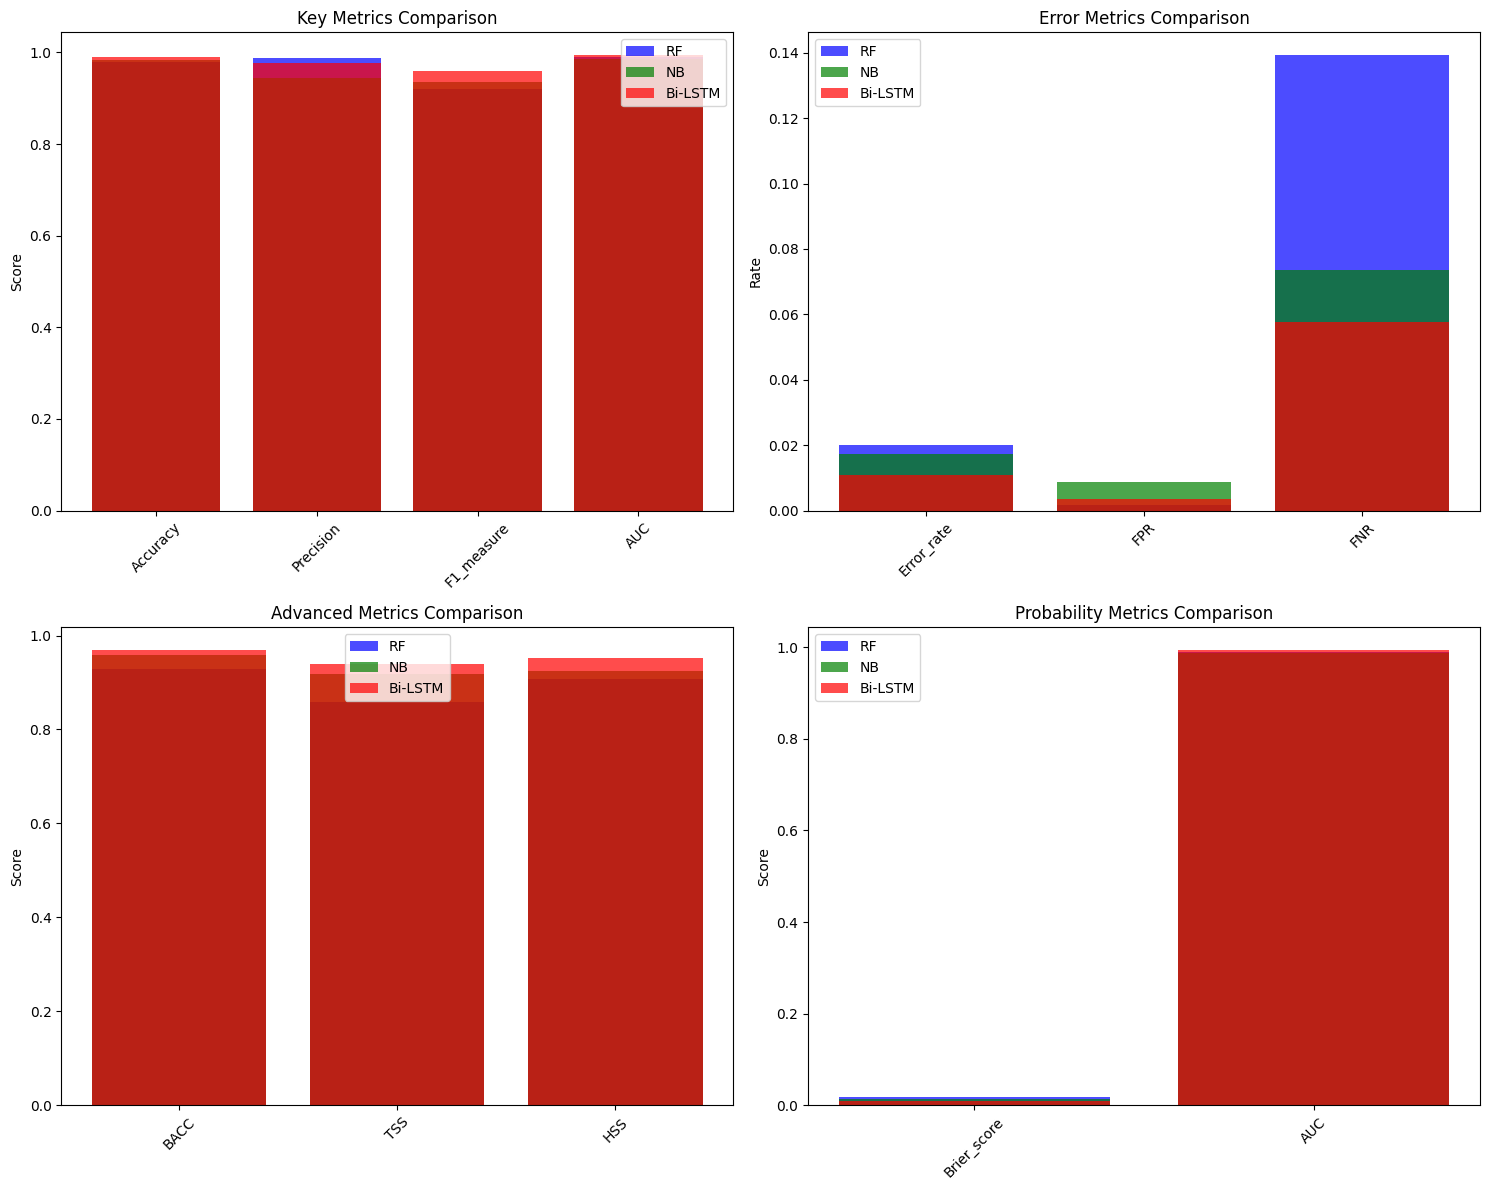

In [24]:
### 5.3 Visualizing Model Performance Comparison

# Plot comparison of key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy, Precision, Recall, F1 comparison
key_metrics_comparison = ['Accuracy', 'Precision', 'F1_measure', 'AUC']
metrics_data = avg_performance_df.loc[key_metrics_comparison]

axes[0, 0].bar(metrics_data.index, metrics_data['Random Forest'], alpha=0.7, label='RF', color='blue')
axes[0, 0].bar(metrics_data.index, metrics_data['Naive Bayes'], alpha=0.7, label='NB', color='green')
axes[0, 0].bar(metrics_data.index, metrics_data['Bi-LSTM'], alpha=0.7, label='Bi-LSTM', color='red')
axes[0, 0].set_title('Key Metrics Comparison')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Error rates comparison
error_metrics = ['Error_rate', 'FPR', 'FNR']
error_data = avg_performance_df.loc[error_metrics]

axes[0, 1].bar(error_data.index, error_data['Random Forest'], alpha=0.7, label='RF', color='blue')
axes[0, 1].bar(error_data.index, error_data['Naive Bayes'], alpha=0.7, label='NB', color='green')
axes[0, 1].bar(error_data.index, error_data['Bi-LSTM'], alpha=0.7, label='Bi-LSTM', color='red')
axes[0, 1].set_title('Error Metrics Comparison')
axes[0, 1].set_ylabel('Rate')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Advanced metrics comparison
advanced_metrics = ['BACC', 'TSS', 'HSS']
advanced_data = avg_performance_df.loc[advanced_metrics]

axes[1, 0].bar(advanced_data.index, advanced_data['Random Forest'], alpha=0.7, label='RF', color='blue')
axes[1, 0].bar(advanced_data.index, advanced_data['Naive Bayes'], alpha=0.7, label='NB', color='green')
axes[1, 0].bar(advanced_data.index, advanced_data['Bi-LSTM'], alpha=0.7, label='Bi-LSTM', color='red')
axes[1, 0].set_title('Advanced Metrics Comparison')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score and AUC comparison
prob_metrics = ['Brier_score', 'AUC']
prob_data = avg_performance_df.loc[prob_metrics]

axes[1, 1].bar(prob_data.index, prob_data['Random Forest'], alpha=0.7, label='RF', color='blue')
axes[1, 1].bar(prob_data.index, prob_data['Naive Bayes'], alpha=0.7, label='NB', color='green')
axes[1, 1].bar(prob_data.index, prob_data['Bi-LSTM'], alpha=0.7, label='Bi-LSTM', color='red')
axes[1, 1].set_title('Probability Metrics Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [25]:
## 6. ROC Curve Analysis

# Random Forest
rf_final = RandomForestClassifier(
    n_estimators=n_estimators_rf,
    max_depth=max_depth_rf,
    min_samples_split=min_samples_split_rf,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_tfidf, y_train)
y_score_rf = rf_final.predict_proba(X_test_tfidf)[:, 1]

# Naive Bayes
nb_final = MultinomialNB(alpha=alpha_nb)
nb_final.fit(X_train_count, y_train)
y_score_nb = nb_final.predict_proba(X_test_count)[:, 1]

# Bi-LSTM
bilstm_final = create_bilstm_model()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
bilstm_final.fit(X_train_seq, y_train_lstm, 
                validation_data=(X_test_seq, y_test_lstm),
                epochs=20, batch_size=64, 
                callbacks=[early_stop], verbose=0)
y_score_bilstm = bilstm_final.predict(X_test_seq, verbose=0).flatten()

# Compute ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_score_nb)
fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test_lstm, y_score_bilstm)

# Compute AUC scores
auc_rf = roc_auc_score(y_test, y_score_rf)
auc_nb = roc_auc_score(y_test, y_score_nb)
auc_bilstm = roc_auc_score(y_test_lstm, y_score_bilstm)

print(f"Random Forest AUC: {auc_rf:.3f}")
print(f"Naive Bayes AUC: {auc_nb:.3f}")
print(f"Bi-LSTM AUC: {auc_bilstm:.3f}")

Generating ROC Curves for All Models...
Training final models on full training set...
Random Forest AUC: 0.989
Naive Bayes AUC: 0.988
Bi-LSTM AUC: 0.992


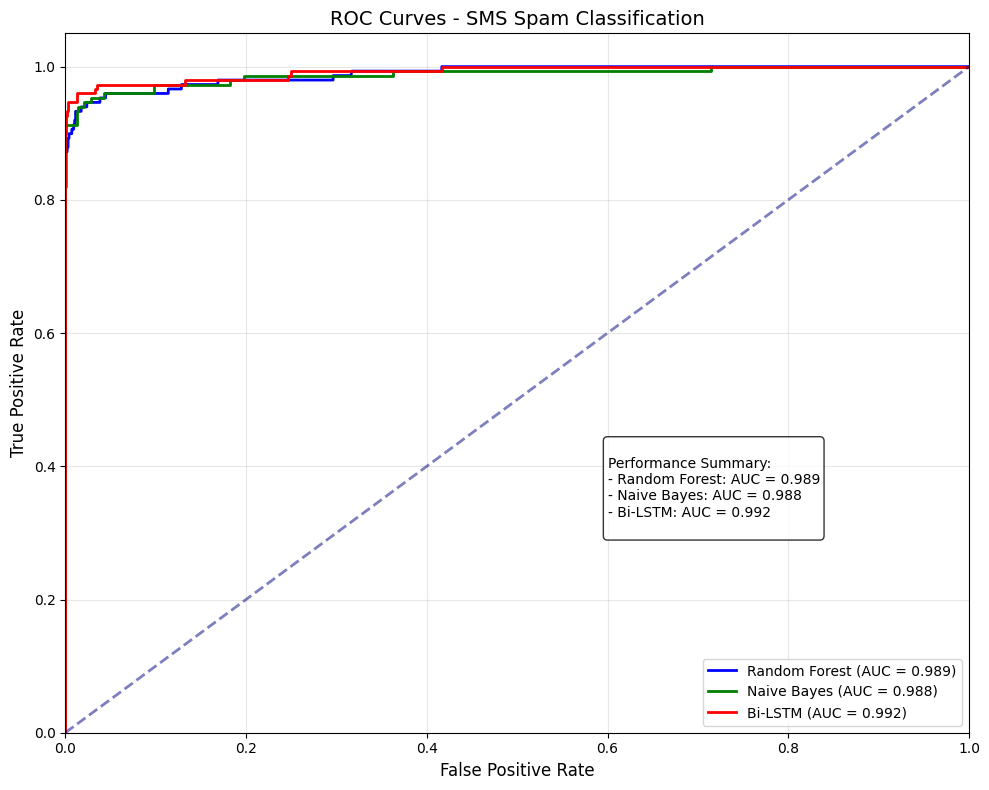

In [26]:
## 6.1 Plot ROC Curves

plt.figure(figsize=(10, 8))

plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, 
         label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, 
         label=f'Naive Bayes (AUC = {auc_nb:.3f})')
plt.plot(fpr_bilstm, tpr_bilstm, color='red', lw=2, 
         label=f'Bi-LSTM (AUC = {auc_bilstm:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - SMS Spam Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)

# Add performance summary box
summary_text = f'''
Performance Summary:
- Random Forest: AUC = {auc_rf:.3f}
- Naive Bayes: AUC = {auc_nb:.3f}
- Bi-LSTM: AUC = {auc_bilstm:.3f}
'''
plt.text(0.6, 0.3, summary_text, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

Generating Confusion Matrices for All Models...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


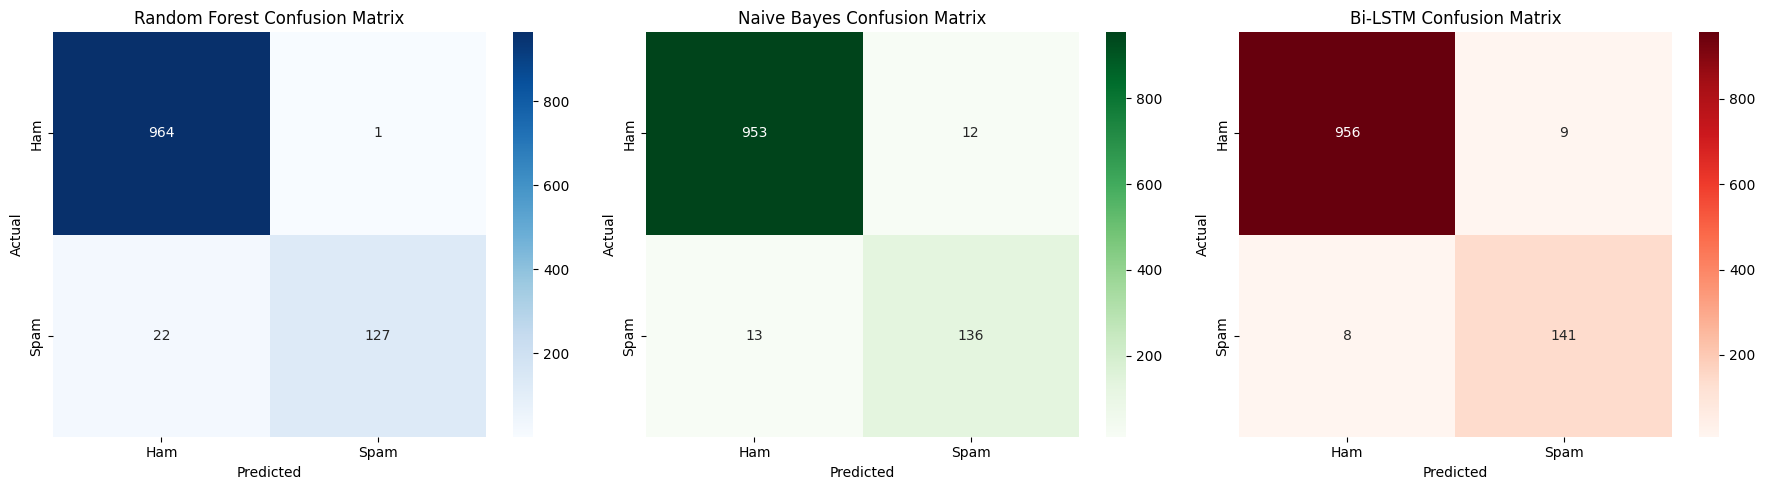


Confusion Matrix Statistics:

Random Forest:
  True Negatives : 964
  False Positives : 1
  False Negatives : 22
  True Positives : 127

Naive Bayes:
  True Negatives : 953
  False Positives : 12
  False Negatives : 13
  True Positives : 136

Bi-LSTM:
  True Negatives : 956
  False Positives : 9
  False Negatives : 8
  True Positives : 141


In [49]:
## Confusion Matrix Visualization

print("Generating Confusion Matrices for All Models...")

# Create confusion matrices for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_final.predict(X_test_tfidf))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Ham', 'Spam'])
axes[0].set_yticklabels(['Ham', 'Spam'])

# Naive Bayes Confusion Matrix  
nb_cm = confusion_matrix(y_test, nb_final.predict(X_test_count))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Naive Bayes Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Ham', 'Spam'])
axes[1].set_yticklabels(['Ham', 'Spam'])

# Bi-LSTM Confusion Matrix
bilstm_pred = (bilstm_final.predict(X_test_seq) > 0.5).astype(int).flatten()
bilstm_cm = confusion_matrix(y_test_lstm, bilstm_pred)
sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Reds', ax=axes[2])
axes[2].set_title('Bi-LSTM Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Ham', 'Spam'])
axes[2].set_yticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Statistics:")
for i, (model, cm, name) in enumerate(zip(
    [rf_final, nb_final, bilstm_final], 
    [rf_cm, nb_cm, bilstm_cm],
    ['Random Forest', 'Naive Bayes', 'Bi-LSTM']
)):
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name}:")
    print(f"  True Negatives : {tn}")
    print(f"  False Positives : {fp}")
    print(f"  False Negatives : {fn}")
    print(f"  True Positives : {tp}")

In [39]:
## 7. Final Model Comparison and Conclusion

print("FINAL MODEL COMPARISON - SMS SPAM CLASSIFICATION")

# Create detailed comparison table
comparison_metrics = [
    'Accuracy', 'Precision', 'F1_measure', 'AUC', 'BACC', 
    'TSS', 'HSS', 'Brier_score', 'Error_rate'
]

final_comparison = avg_performance_df.loc[comparison_metrics]

def highlight_best(row):
    best_idx = row.astype(float).idxmax() if row.name != 'Brier_score' and row.name != 'Error_rate' else row.astype(float).idxmin()
    return ['background-color: lightgreen' if col == best_idx else '' for col in row.index]

styled_comparison = final_comparison.style.apply(highlight_best, axis=1)
print("\nPerformance Comparison (Average across 10 folds):")

# Determine best model overall
overall_scores = {}
for model in ['Random Forest', 'Naive Bayes', 'Bi-LSTM']:
    # Higher is better for most metrics, lower is better for error metrics
    score = (final_comparison.loc[['Accuracy', 'Precision', 'F1_measure', 'AUC', 'BACC', 'TSS', 'HSS'], model].mean() -
             final_comparison.loc[['Brier_score', 'Error_rate'], model].mean())
    overall_scores[model] = score

best_model = max(overall_scores, key=overall_scores.get)

print(f"\nBEST OVERALL MODEL - {best_model}")
print(f"Overall Score - {overall_scores[best_model]:.3f}")

print("\nModel Rankings -")
for i, (model, score) in enumerate(sorted(overall_scores.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"{i}. {model}: {score:.3f}")

FINAL MODEL COMPARISON - SMS SPAM CLASSIFICATION

Performance Comparison (Average across 10 folds):

BEST OVERALL MODEL - Bi-LSTM
Overall Score - 0.959

Model Rankings -
1. Bi-LSTM: 0.959
2. Naive Bayes: 0.934
3. Random Forest: 0.920
